In [9]:
import sys 
import os
%load_ext autoreload
sys.path.insert(0, '../../Churn_Prediction')
from src.config import TRAINING_FILE,MODELS,MODEL_TRAINING_FILE
from src.utility import get_spark

from pyspark.ml import Pipeline
from pyspark.ml.feature import  StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, lit,when
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, NaiveBayes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:

infer_schema = "True"
first_row_is_header = "True"
delimiter = ","
file_type = 'csv'
# The applied options are for CSV files. For other file types, these will be ignored.
df = get_spark().read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(TRAINING_FILE)

display(df.toPandas())

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes



### Data Modeling and Transformation

In [10]:
stages = []
categoricalColumns = ['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection',
                     'TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod']
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    stages += [stringIndexer]
label_stringIdx = StringIndexer(inputCol = 'Churn', outputCol = 'label')
stages += [label_stringIdx]

In [11]:
numericCols = list(set(df.columns) - set(categoricalColumns) - set(['customerID','Churn','TotalCharges']))

In [12]:
assemblerInputs = [c + "Index" for c in categoricalColumns] + numericCols

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

stages += [assembler]

In [13]:
# Fitting Pipeline
  
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(df)

In [14]:
preppedDataDF = pipelineModel.transform(df)

In [15]:
selectedcols = ["label", "features"] + df.columns
dataset = preppedDataDF.select(selectedcols)

dataset.toPandas().head(5)

22/12/02 22:49:14 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,label,features,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0.0,"(1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, ...",7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...",5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, ...",3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,0.0,"[0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, ...",7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [16]:
train, test = dataset.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 4978
Test Dataset Count: 2065


In [17]:
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# Train model with Training Data with Logistic Regression
lrModel = lr.fit(train)

22/12/02 22:53:22 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/12/02 22:53:22 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [18]:
rf = RandomForestClassifier(numTrees=50,labelCol="label", featuresCol="features")
rfModel = rf.fit(train)

In [19]:
nb = NaiveBayes(labelCol="label", featuresCol="features")
nb_model=nb.fit(train)

##Result Evaluation

In [20]:
lrPreds = lrModel.transform(test)
lrPreds.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[1.54912318396661...|       0.0|[0.82478705628038...|
|  0.0|[0.92347404384520...|       0.0|[0.71574943694594...|
|  0.0|[2.06177256561138...|       0.0|[0.88713177695782...|
|  0.0|[0.38051880544234...|       0.0|[0.59399822640189...|
|  0.0|[0.30574938941935...|       0.0|[0.57584739768481...|
|  0.0|[0.49924862729729...|       0.0|[0.62228273958712...|
|  0.0|[1.07518294054183...|       0.0|[0.74558131764321...|
|  0.0|[-1.0520595510986...|       1.0|[0.25882980663795...|
|  0.0|[2.11268182997317...|       0.0|[0.89212968882572...|
|  0.0|[0.14222387596801...|       0.0|[0.53549615555941...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [21]:
rfPreds = rfModel.transform(test)
rfPreds.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[39.0009333464307...|       0.0|[0.78001866692861...|
|  0.0|[37.2562957183603...|       0.0|[0.74512591436720...|
|  0.0|[41.9698781833610...|       0.0|[0.83939756366722...|
|  0.0|[34.6441051471068...|       0.0|[0.69288210294213...|
|  0.0|[34.9681731203446...|       0.0|[0.69936346240689...|
|  0.0|[32.3174444081074...|       0.0|[0.64634888816214...|
|  0.0|[37.6907354062137...|       0.0|[0.75381470812427...|
|  0.0|[18.7383938975255...|       1.0|[0.37476787795051...|
|  0.0|[40.5275125311947...|       0.0|[0.81055025062389...|
|  0.0|[26.8297511132017...|       0.0|[0.53659502226403...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [22]:
nbPreds = nb_model.transform(test)
nbPreds.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[-103.65588462032...|       0.0|[0.99999831429466...|
|  0.0|[-78.300011694737...|       0.0|[0.99912618195443...|
|  0.0|[-121.80837416420...|       0.0|[0.99992038793878...|
|  0.0|[-79.374418966913...|       1.0|[1.88782908889000...|
|  0.0|[-78.022594070525...|       1.0|[4.44003316263294...|
|  0.0|[-68.448027180011...|       1.0|[4.49875297839412...|
|  0.0|[-144.38630541933...|       0.0|[0.83767837019217...|
|  0.0|[-102.32938068158...|       1.0|[6.08629549773015...|
|  0.0|[-169.42913613205...|       0.0|[0.99999997858692...|
|  0.0|[-131.96571641221...|       1.0|[0.07456041711041...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [24]:


correct = lrPreds.where("(label = prediction)").count()
incorrect = lrPreds.where("(label != prediction)").count()

resultDF = get_spark().createDataFrame([['correct', correct], ['incorrect', incorrect]], ['metric', 'value'])
display(resultDF)

DataFrame[metric: string, value: bigint]

In [25]:
# AUC 
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(lrPreds)

0.837829485114253

In [42]:
print("Classification report of Logistic")
lrPreds.groupBy('label', 'prediction').count().show()
# Calculate the elements of the confusion matrix
TN = lrPreds.filter('prediction = 0 AND label = prediction').count()
TP = lrPreds.filter('prediction = 1 AND label = prediction').count()
FN = lrPreds.filter('prediction = 0 AND label <> prediction').count()
FP = lrPreds.filter('prediction = 1 AND label <> prediction').count()
# calculate accuracy, precision, recall, and F1-score
accuracy = (TN + TP) / (TN + TP + FN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F =  2 * (precision*recall) / (precision + recall)
print('n precision: %0.3f' % precision)
print('n recall: %0.3f' % recall)
print('n accuracy: %0.3f' % accuracy)
print('n F1 score: %0.3f' % F)

Classification report of Logistic


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  290|
|  0.0|       1.0|  139|
|  1.0|       0.0|  265|
|  0.0|       0.0| 1371|
+-----+----------+-----+

n precision: 0.676
n recall: 0.523
n accuracy: 0.804
n F1 score: 0.589


In [26]:
correct = rfPreds.where("(label = prediction)").count()
incorrect = rfPreds.where("(label != prediction)").count()

resultDF_RF = get_spark().createDataFrame([['correct', correct], ['incorrect', incorrect]], ['metric', 'value'])
display(resultDF_RF)

DataFrame[metric: string, value: bigint]

In [27]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(rfPreds)

0.8420828112881107

In [43]:
print("Classification report of Random Forest")
rfPreds.groupBy('label', 'prediction').count().show()
# Calculate the elements of the confusion matrix
TN = rfPreds.filter('prediction = 0 AND label = prediction').count()
TP = rfPreds.filter('prediction = 1 AND label = prediction').count()
FN = rfPreds.filter('prediction = 0 AND label <> prediction').count()
FP = rfPreds.filter('prediction = 1 AND label <> prediction').count()
# calculate accuracy, precision, recall, and F1-score
accuracy = (TN + TP) / (TN + TP + FN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F =  2 * (precision*recall) / (precision + recall)
print('n precision: %0.3f' % precision)
print('n recall: %0.3f' % recall)
print('n accuracy: %0.3f' % accuracy)
print('n F1 score: %0.3f' % F)

Classification report of Random Forest
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  216|
|  0.0|       1.0|   92|
|  1.0|       0.0|  339|
|  0.0|       0.0| 1418|
+-----+----------+-----+

n precision: 0.701
n recall: 0.389
n accuracy: 0.791
n F1 score: 0.501


In [28]:
correct = nbPreds.where("(label = prediction)").count()
incorrect = nbPreds.where("(label != prediction)").count()

resultDF_NB = get_spark().createDataFrame([['correct', correct], ['incorrect', incorrect]], ['metric', 'value'])
display(resultDF_NB)

DataFrame[metric: string, value: bigint]

In [29]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(nbPreds)

0.7852723584511644

In [44]:
print("Classification report of Naive Bayes")
nbPreds.groupBy('label', 'prediction').count().show()
# Calculate the elements of the confusion matrix
TN = nbPreds.filter('prediction = 0 AND label = prediction').count()
TP = nbPreds.filter('prediction = 1 AND label = prediction').count()
FN = nbPreds.filter('prediction = 0 AND label <> prediction').count()
FP = nbPreds.filter('prediction = 1 AND label <> prediction').count()
# calculate accuracy, precision, recall, and F1-score
accuracy = (TN + TP) / (TN + TP + FN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F =  2 * (precision*recall) / (precision + recall)
print('n precision: %0.3f' % precision)
print('n recall: %0.3f' % recall)
print('n accuracy: %0.3f' % accuracy)
print('n F1 score: %0.3f' % F)

Classification report of Naive Bayes
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  411|
|  0.0|       1.0|  397|
|  1.0|       0.0|  144|
|  0.0|       0.0| 1113|
+-----+----------+-----+

n precision: 0.509
n recall: 0.741
n accuracy: 0.738
n F1 score: 0.603


##Cross Validation

In [30]:

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

In [31]:
# Running with Cross validation
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(train)

In [32]:
predictions = cvModel.transform(test)

In [33]:
correct = predictions.where("(label = prediction)").count()
incorrect = predictions.where("(label != prediction)").count()

resultDF_cv = get_spark().createDataFrame([['correct', correct], ['incorrect', incorrect]], ['metric', 'value'])
display(resultDF_cv)

DataFrame[metric: string, value: bigint]

In [34]:
evaluator.evaluate(predictions)

0.8393037408269177

In [45]:
print("Classification report of Logistic with CV")
predictions.groupBy('label', 'prediction').count().show()
# Calculate the elements of the confusion matrix
TN = predictions.filter('prediction = 0 AND label = prediction').count()
TP = predictions.filter('prediction = 1 AND label = prediction').count()
FN = predictions.filter('prediction = 0 AND label <> prediction').count()
FP = predictions.filter('prediction = 1 AND label <> prediction').count()
# calculate accuracy, precision, recall, and F1-score
accuracy = (TN + TP) / (TN + TP + FN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F =  2 * (precision*recall) / (precision + recall)
print('n precision: %0.3f' % precision)
print('n recall: %0.3f' % recall)
print('n accuracy: %0.3f' % accuracy)
print('n F1 score: %0.3f' % F)

Classification report of Logistic with CV
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  280|
|  0.0|       1.0|  128|
|  1.0|       0.0|  275|
|  0.0|       0.0| 1382|
+-----+----------+-----+

n precision: 0.686
n recall: 0.505
n accuracy: 0.805
n F1 score: 0.582


In [35]:
paramGrid_RF = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5, 10, 15])
             .build())


In [36]:
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid_RF, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel_rf = cv_rf.fit(train)

22/12/02 22:56:25 WARN DAGScheduler: Broadcasting large task binary with size 1039.5 KiB
22/12/02 22:56:25 WARN DAGScheduler: Broadcasting large task binary with size 1706.7 KiB
22/12/02 22:56:25 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/12/02 22:56:26 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/12/02 22:56:27 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/12/02 22:56:29 WARN DAGScheduler: Broadcasting large task binary with size 1039.5 KiB
22/12/02 22:56:29 WARN DAGScheduler: Broadcasting large task binary with size 1706.7 KiB
22/12/02 22:56:30 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/12/02 22:56:31 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/12/02 22:56:32 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/12/02 22:56:33 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/12/02 22:56:34 WARN DAGScheduler: Broad

In [37]:
predictions_rf = cvModel_rf.transform(test)


In [38]:
correct = predictions_rf.where("(label = prediction)").count()
incorrect = predictions_rf.where("(label != prediction)").count()

resultDF_cv = get_spark().createDataFrame([['correct', correct], ['incorrect', incorrect]], ['metric', 'value'])
display(resultDF_cv)

DataFrame[metric: string, value: bigint]

In [39]:
evaluator.evaluate(predictions_rf)

0.8420828112881107

In [46]:
print("Classification report of Random Forest with CV")
predictions_rf.groupBy('label', 'prediction').count().show()
# Calculate the elements of the confusion matrix
TN = predictions_rf.filter('prediction = 0 AND label = prediction').count()
TP = predictions_rf.filter('prediction = 1 AND label = prediction').count()
FN = predictions_rf.filter('prediction = 0 AND label <> prediction').count()
FP = predictions_rf.filter('prediction = 1 AND label <> prediction').count()
# calculate accuracy, precision, recall, and F1-score
accuracy = (TN + TP) / (TN + TP + FN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F =  2 * (precision*recall) / (precision + recall)
print('n precision: %0.3f' % precision)
print('n recall: %0.3f' % recall)
print('n accuracy: %0.3f' % accuracy)
print('n F1 score: %0.3f' % F)

Classification report of Random Forest with CV
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  216|
|  0.0|       1.0|   92|
|  1.0|       0.0|  339|
|  0.0|       0.0| 1418|
+-----+----------+-----+

n precision: 0.701
n recall: 0.389
n accuracy: 0.791
n F1 score: 0.501


In [47]:
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

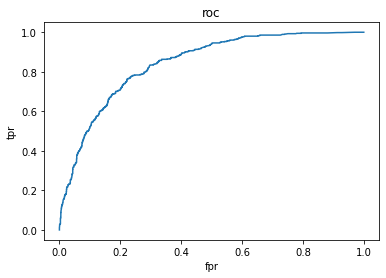

In [50]:
import matplotlib.pyplot as plt
preds = predictions_rf.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title("roc for rf with cv")
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot(x_val, y_val)

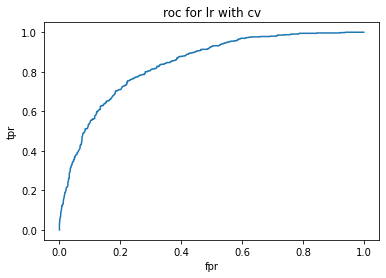

In [52]:
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title("roc for lr with cv")
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot(x_val, y_val)

In [56]:
lrModel.save('../models/logistic_regression')